# CS5487 Programming Assignment 1 Regression

## Name: WANG Huanchen

## Student ID: 57558749

## Part one

In [1]:
# import each library for assignment
import random
import numpy as np
import cmath
import matplotlib.pyplot as plt
from cvxopt import matrix
from cvxopt import solvers

solvers.options['show_progress']=False

In [2]:
# load and process data


def data_processing(part=0):

    if part==0:
        sample_X = np.loadtxt('./PA-1-data-text/polydata_data_sampx.txt')
        sample_Y = np.loadtxt('./PA-1-data-text/polydata_data_sampy.txt')
        poly_X = np.loadtxt('./PA-1-data-text/polydata_data_polyx.txt')
        poly_Y = np.loadtxt('./PA-1-data-text/polydata_data_polyy.txt')

        true_theta = np.loadtxt('./PA-1-data-text/polydata_data_thtrue.txt')
        sample_X = sample_X.reshape(1, sample_X.shape[0])
        sample_Y = sample_Y.reshape(sample_Y.shape[0], 1)

        poly_X = poly_X.reshape(1, poly_X.shape[0])
        poly_Y = poly_Y.reshape(poly_Y.shape[0], 1)
    else:
        sample_X = np.loadtxt('./PA-1-data-text/count_data_trainx.txt')
        sample_Y = np.loadtxt('./PA-1-data-text/count_data_trainy.txt')
        poly_X = np.loadtxt('./PA-1-data-text/count_data_testx.txt')
        poly_Y = np.loadtxt('./PA-1-data-text/count_data_testy.txt')

        sample_X = sample_X.reshape(sample_X.shape[0], sample_X.shape[1])
        sample_Y = sample_Y.reshape(sample_Y.shape[0], 1)

        poly_X = poly_X.reshape(poly_X.shape[0], poly_X.shape[1])
        poly_Y = poly_Y.reshape(poly_Y.shape[0], 1)
    

    return sample_X, sample_Y, poly_X, poly_Y

def Phi_2(Sample):
    return np.concatenate((Sample, Sample**2), axis=0)

def Phi_3 (Sample):
    return np.concatenate((Sample, Sample**2, Sample**3), axis=0)

def Phi_ij(Sample):
    mat_2 = Phi_2(Sample)
    sample_sq = np.dot(Sample, Sample.T)
    return sample_sq[np.triu_indices(Sample.shape[0], k = 1)].reshape(-1,1) 

# generate Phi(x).
def generate_Phix(X, K):
    return np.array( [ X**k for k in range(K+1)]).reshape(K+1, 1)

# generate Big Phi matrix dimen is (K, N).
def generate_Phi_mat(Sample, K, mode=0):
    if mode==0:
        return np.array( [generate_Phix(x, K) for x in Sample[0]])[:,:, (Sample.shape[0]-1)].T
    elif mode==1:
        # for Phi(x) = x, Phi_mat is (((dim of feature in each sample) * 1) , N)
        return np.concatenate( ([ S.reshape(Sample.shape[0],1) for S in Sample.T]) ,axis=1)       
    elif mode==2:
        # for Phi(x) = {x, x^2}, (((dim of each feature vector) * 2) , N)
        return np.concatenate( ([Phi_2(S.reshape(Sample.shape[0],1)) for S in Sample.T]) ,axis=1)      
    elif mode==3:
        # for Phi(x) = {x, xi * xj, x^2} 
        return np.concatenate( ([np.concatenate( (Phi_2(S.reshape(Sample.shape[0],1)), Phi_ij(S.reshape(Sample.shape[0],1))), axis=0) for S in Sample.T]) ,axis=1)  
    elif mode==4:
        # return np.concatenate( ([np.concatenate( (S.reshape(Sample.shape[0],1), Phi_ij(S.reshape(Sample.shape[0],1))), axis=0) for S in Sample.T]) ,axis=1)
        return np.concatenate( ([Phi_3(S.reshape(Sample.shape[0],1)) for S in Sample.T]) ,axis=1)     

# Do the prediction though the fixed Theta.
def pred_polyY(polyX, Theta, mode=0):
    # Theta dim: (K+1, 1)
    Phi_mat_T = generate_Phi_mat(polyX, Theta.shape[0]-1, mode).T
    pred_Y = np.dot(Phi_mat_T, Theta)
    return pred_Y

In [3]:
# each model of regression 

def least_squares_Theta(SampleX, SampleY, K, mode=0):
    Phi_mat = generate_Phi_mat(SampleX, K, mode)
    Theta = np.dot(np.linalg.inv(np.dot(Phi_mat, Phi_mat.T)), np.dot(Phi_mat, SampleY))
    return Theta

def Regular_LS_Theta(SampleX, SampleY, K, lbda=0.1, mode=0):
    Phi_mat = generate_Phi_mat(SampleX, K, mode=mode)
    Theta = np.dot(np.linalg.inv(np.dot(Phi_mat, Phi_mat.T) + lbda * np.ones((Phi_mat.shape[0], Phi_mat.shape[0]))), np.dot(Phi_mat, SampleY))
    return Theta

def L1_LS_Theta(SampleX, SampleY, K, lbda=1, mode=0):
    # refer to the Problem Set 3.12
    # To solve Lasso, construct the matrix: 
    # X dimen:(2(K+1), 1), H dimen:(2(K+1), 2(K+1)), f dimen:(2(K+1), 1), G and h based on constraint dimen: (2(K+1), 2(K+1)), h (2(K+1), 1) matrix
    Phi_mat = generate_Phi_mat(SampleX, K, mode=mode)
    Phi_square = np.dot(Phi_mat, Phi_mat.T)
    Phi_y = np.dot(Phi_mat, SampleY)
    H_left = np.concatenate((Phi_square, -Phi_square), axis=0)
    H = np.concatenate( (H_left, -H_left), axis=1 )
    f = lbda*np.ones((H.shape[0], 1)) - np.concatenate( (Phi_y, -Phi_y), axis=0 )
    G = - np.identity(H.shape[0])
    h = np.zeros( (H.shape[0], 1) )
    Lasso_theta = solvers.qp(P=matrix(H), q=matrix(f), G=matrix(G), h=matrix(h))['x']
    Lasso_theta = np.matrix(Lasso_theta)
    # Lasso_theta is  [theta+, theta-]T, to get the theta = theta+ - theta-
    Theta = Lasso_theta[: int(H.shape[0]/2)] - Lasso_theta[ int(H.shape[0]/2):]
    Theta = np.array(Theta)
    return Theta
    
def Robust_LS(SampleX, SampleY, K, mode=0):
     # refer to the Problem Set 2.10
    # To solve Robust, construct the matrix: 
    # X dimen:((K+1) + N, 1), f dimen:((K+1) + N, 1), , A and b based on constraint dimen:(2N, (K+1) + N), b (2N， 1) matrix
    Phi_mat = generate_Phi_mat(SampleX, K, mode=mode)
    f = np.concatenate((np.zeros((Phi_mat.shape[0], 1)), np.ones((SampleX.shape[1],1))), axis=0)
    A_left = np.concatenate( (-Phi_mat.T, Phi_mat.T), axis=0 )
    A_right = np.concatenate( (-np.identity(SampleX.shape[1]), -np.identity(SampleX.shape[1])), axis=0)
    A = np.concatenate( (A_left, A_right), axis=1 )
    b = np.concatenate((-SampleY, SampleY))
    Robust_theta = solvers.lp(G=matrix(A),c=matrix(f), h=matrix(b))['x']
    Theta = np.array(Robust_theta[: Phi_mat.shape[0]])
    return Theta

def Bayes_post(SampleX, SampleY, sigma_square, K, alpha=1, mode=0):
    Phi_mat = generate_Phi_mat(SampleX, K, mode=mode)
    Cov_mat = np.linalg.inv((1/alpha * np.identity((Phi_mat.shape[0])) + 1/sigma_square * np.dot(Phi_mat, Phi_mat.T)))
    Mu_theta = 1/(sigma_square)* np.dot(Cov_mat, np.dot(Phi_mat, SampleY) )
    return Mu_theta, Cov_mat

def Bayes_pred(Mu, Cov, PolyX, mode=0):
    # Mu dim (K+1, 1)
    Phi_mat = generate_Phi_mat(PolyX, Mu.shape[0]-1, mode=mode)
    pred = np.dot(Phi_mat.T, Mu)
    pred_var = np.dot(Phi_mat.T, np.dot(Cov, Phi_mat))
    std_var = np.sqrt(pred_var.diagonal())
    return pred, std_var


In [4]:
# utils for Part1

def hyperpara(samplex, sampley, x, y, K, model, mode=0):
    para = 0
    err = cmath.inf
    if model=='L1':
        para_list = np.linspace(0,1,20)
        for lbda in para_list:
            L1_theta = L1_LS_Theta(samplex, sampley, K, lbda, mode)
            pred = pred_polyY(x, L1_theta, mode)
            mse = MSE(pred, y)
            if mse < err:
                err = mse
                para = lbda
    if model == 'RLS':
        para_list =  np.linspace(0,1,20)
        for lbda in para_list:
            RLS_theta = Regular_LS_Theta(samplex, sampley, K, lbda, mode)
            pred = pred_polyY(x, RLS_theta, mode)
            mse = MSE(pred, y)
            if mse < err:
                err = mse
                para = lbda    
    if model == 'BR':
        para_list = np.linspace(0,5,50)
        for alpha in para_list:
            mu, cov = Bayes_post(samplex, sampley, 5, K, alpha, mode)
            pred, std = Bayes_pred(mu, cov, x, mode)
            mse = MSE(pred, y)
            if mse < err:
                err = mse
                para = alpha   
    return para


def MSE(pred, true):
    # L2 is sqrt(y1^2 + y2^2 .... yn^2)
    return np.linalg.norm(true-pred, ord=2)**2/len(pred)

def MAE(pred, true):
    return np.linalg.norm(true-pred, ord=1)/len(pred)


def seperate_data(data, ratio):
    r_len = ratio * len(data)
    np.random.shuffle(data)
    sample_x = data[:, 0].reshape(1, -1)[:, :int(r_len)]
    sample_y = data[:, 1].reshape(-1, 1)[:int(r_len), :]
    return sample_x, sample_y

In [5]:
# plot charts for a b

def plot_MSE_MAE(model, which='mse'):
    if which=='mse':
        plt.title('The MSE of Each Model')
    else:
        plt.title('The MAE of Each Model')
    plt.bar(model.keys(), model.values())
    plt.show()
    

def plot_each_model(samplex, sampley, X, pred_dict, Y, color_map):
    plt.figure(figsize=(15,20))

    ax1 = plt.subplot(321)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.scatter(X[0], pred_dict['LS'], c=color_map['LS'], label='LS',s=10)
    ax1.scatter(samplex[0], sampley, label='Samples',s=10)
    ax1.plot(X[0], Y, 'r-', label='True Value')
    plt.legend()

    ax2 = plt.subplot(322)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.scatter(X[0], pred_dict['RLS'], c=color_map['RLS'], label='RLS', s=10)
    ax2.scatter(samplex[0], sampley, label='Samples',s=10)
    ax2.plot(X[0], Y, 'r-', label='True Value')
    plt.legend()

    ax3 = plt.subplot(323)
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.scatter(X[0], pred_dict['LASSO'], c=color_map['LASSO'], label='LASSO', s=10)
    ax3.scatter(samplex[0], sampley, label='Samples',s=10)
    ax3.plot(X[0], Y, 'r-', label='True Value')
    plt.legend()

    ax4 = plt.subplot(324)
    ax4.set_xlabel('x')
    ax4.set_ylabel('y')
    ax4.scatter(X[0], pred_dict['RR'], c=color_map['RR'], label='RR', s=10)
    ax4.scatter(samplex[0], sampley, label='Samples',s=10)
    ax4.plot(X[0], Y, 'r-', label='True Value')
    plt.legend()

    ax5 = plt.subplot(325)
    ax5.set_xlabel('x')
    ax5.set_ylabel('y')
    ax5.scatter(X[0], pred_dict['BR'], c=color_map['BR'], label='BR', s=10)
    ax5.scatter(X[0], pred_dict['BR_pos'], c=color_map['BR_pos'], label='BR_pos', s=10)
    ax5.scatter(X[0], pred_dict['BR_neg'], c=color_map['BR_neg'], label='BR_neg', s=10)
    ax5.scatter(samplex[0], sampley, label='Samples',s=10)
    ax5.plot(X[0], Y, 'r-', label='True Value')
    plt.legend()
    plt.show()

 # plot chart for c
 # Plot the chart for pro C
def plot_probc_est(X, Y, model_dict):
    plt.figure(figsize=(17,10))

    ax1 = plt.subplot(321)
    # ls
    ax1.set_title('LS model')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    size_color_map = {0.15:'brown', 0.25:'chocolate', 0.5:'green', 0.75:'pink', 1:'orange'}
    for k, v in model_dict.items():
        ax1.scatter(X[0], v['LS'], c=size_color_map[k], label=k, s=10)
    ax1.plot(X[0], Y, 'r-', label='True Value')
    plt.legend()

    ax2 = plt.subplot(322)
    # RLS
    ax2.set_title('RLS model')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    size_color_map = {0.15:'brown', 0.25:'chocolate', 0.5:'green', 0.75:'pink', 1:'orange'}
    for k, v in model_dict.items():
        ax2.scatter(X[0], v['RLS'], c=size_color_map[k], label=k, s=10)
    ax2.plot(X[0], Y, 'r-', label='True Value')
    plt.legend()

    ax3 = plt.subplot(323)
    # LASSO
    ax3.set_title('LASSO model')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    size_color_map = {0.15:'brown', 0.25:'chocolate', 0.5:'green', 0.75:'pink', 1:'orange'}
    for k, v in model_dict.items():
        ax3.scatter(X[0], v['LASSO'], c=size_color_map[k], label=k, s=10)
    ax3.plot(X[0], Y, 'r-', label='True Value')
    plt.legend()

    ax4 = plt.subplot(324)
    # RR
    ax4.set_title('RR model')
    ax4.set_xlabel('x')
    ax4.set_ylabel('y')
    size_color_map = {0.15:'brown', 0.25:'chocolate', 0.5:'green', 0.75:'pink', 1:'orange'}
    for k, v in model_dict.items():
        ax4.scatter(X[0], v['RR'], c=size_color_map[k], label=k, s=10)
    ax4.plot(X[0], Y, 'r-', label='True Value')
    plt.legend()

    ax5 = plt.subplot(325)
    # BR
    ax5.set_title('BR model')
    ax5.set_xlabel('x')
    ax5.set_ylabel('y')
    size_color_map = {0.15:'brown', 0.25:'blue', 0.5:'green', 0.75:'pink', 1:'orange'}
    for k, v in model_dict.items():
        ax5.scatter(X[0], v['BR'], c=size_color_map[k], label=k, s=10)
    ax5.plot(X[0], Y, 'r-', label='True Value')
    plt.legend()

    # plt.subplots_adjust()
    plt.show()
    

def plot_std_size(ratio_list, model_mse):
    plt.figure(figsize=(10,10))
    plt.title('Each Model\'s MSE in each Ratio')
    plt.xlabel('Ratio')
    plt.ylabel('MSE')
    LS_list = []
    RLS_llist = []
    L1_list = []
    RR_list = []
    BR_list = []
    for k, v in model_mse.items():
        LS_list.append(v['LS'])
        RLS_llist.append(v['RLS'])
        L1_list.append(v['LASSO'])
        RR_list.append(v['RR'])
        BR_list.append(v['BR'])
    plt.plot(ratio_list, LS_list, color='brown', marker='*', label='LS')
    plt.plot(ratio_list, RLS_llist, color='blue', marker='*', label='RLS')
    plt.plot(ratio_list, L1_list, color='green', marker='*', label='LASSO')
    plt.plot(ratio_list, RR_list, color='pink', marker='*', label='RR')
    plt.plot(ratio_list, BR_list, color='orange', marker='*', label='BR')
    plt.legend()
    plt.show()   

# plot chart for d    

### Part 1 Problem a and b
1. To the problem a: those 5 models have been implemented from the above cell codes.
2. To the problem b: 
   + Each model's estimated function using polyx as inputs, along with the sample data was ploted as below. And for BR, their standard deviation around mean was also ploted.
   + What is the mean-squared error between the learned function outputs and the true function outputs (polyy), averaged over all input values in polyx?: According to the below output, the MSE:
         MSE of LS: 0.40864388356990694
         MSE of RLS: 0.40856585482590013
         MSE of LASSO: 0.4086438835746234
         MSE of RR: 0.768046150513354
         MSE of BR: 0.4086325708837267
   +  For algorithms with hyperparameters, select some values that tend to work well:  I implement a function called **hyperpara** for some models, which need hyperparameters. This function can choose a range of hyperparametes and train the model by each of them. It can select a hyperparameter, which make the estimate's error is minimum.  In **anlysis** function, can see that invoking.


c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply


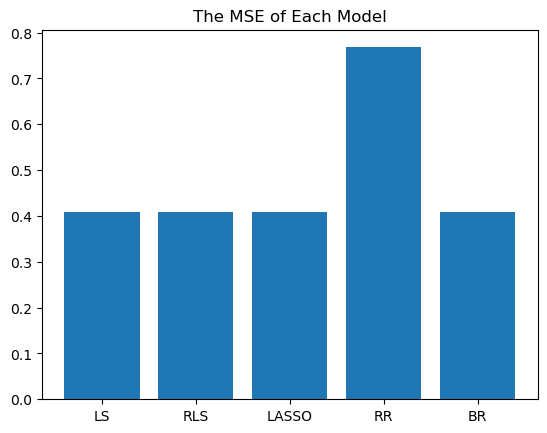

MSE of LS: 0.4086438835698565
MSE of RLS: 0.40856585482579666
MSE of LASSO: 0.4086438835745854
MSE of RR: 0.7680461505133516
MSE of BR: 0.4086325708836395


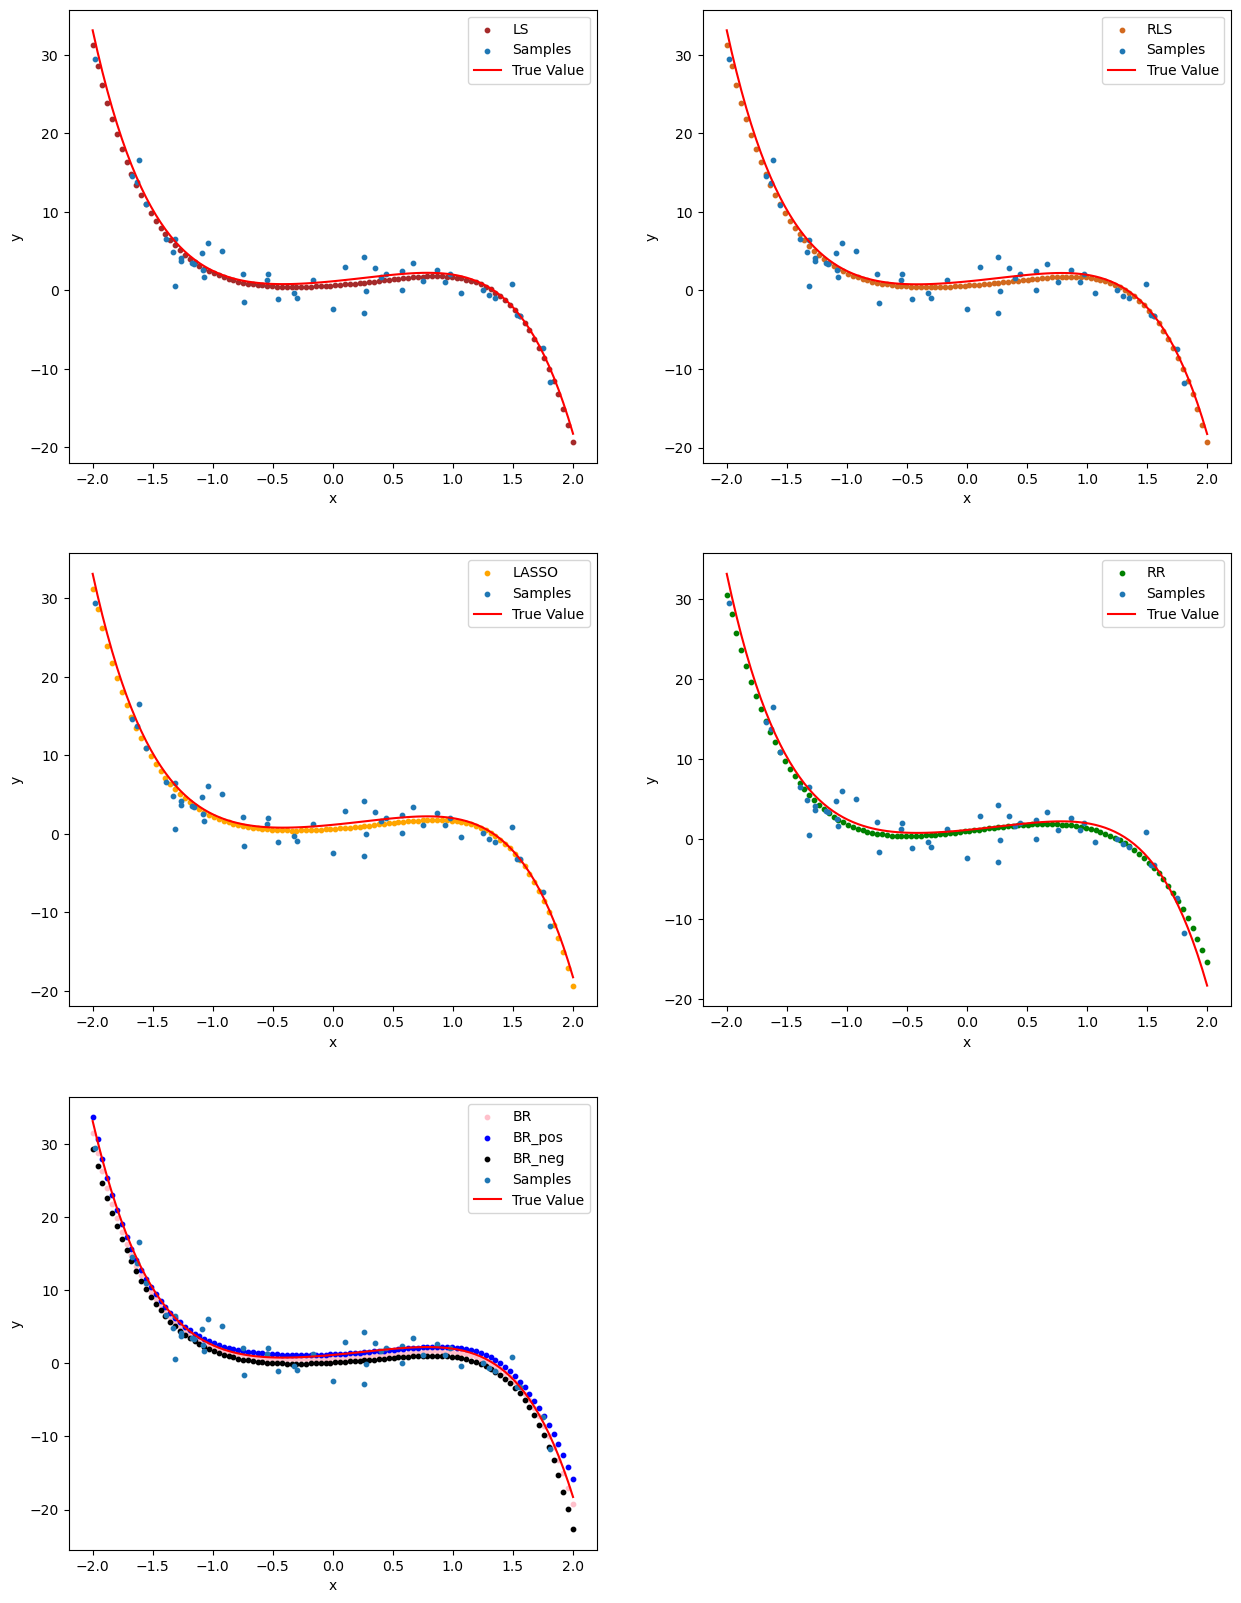

In [6]:
def analysis(ratio=1, K=5, pro='a', outlier=1, part=0):
    x, y, b, d = data_processing(part=part)

    if part==0:
        data_xy= np.ndarray((len(y), 2))
        data_xy[:, 0] = x
        data_xy[:, 1] = y.reshape(1,-1)    
        x, y = seperate_data(data_xy, ratio)
        y[:5, :] = outlier * y[:5, :]
    
    hyper_L1 = hyperpara(x, y, b, d, K, 'L1', mode=part)

    hyper_RLS = hyperpara(x, y, b, d, K, 'RLS', mode=part)

    hyper_BR = hyperpara(x, y, b, d, K, 'BR', mode=part)

    ls_theta = least_squares_Theta(x, y, K, mode=part)
    Regular_theta = Regular_LS_Theta(x, y, K, hyper_RLS, mode=part)
    L1_theta = L1_LS_Theta(x, y, K, hyper_L1, mode=part)
    Robust_theta = Robust_LS(x, y, K, mode=part)
    Mu_theta, cov_theta = Bayes_post(x,y,K,5, hyper_BR, mode=part)

    pred_ls = pred_polyY(b, ls_theta, part)
    pred_Regular = pred_polyY(b, Regular_theta, part)
    pred_L1 = pred_polyY(b, L1_theta, part)
    pred_Robust = pred_polyY(b, Robust_theta, part)
    pred_bayes, std_var = Bayes_pred(Mu_theta, cov_theta, b, part)
    std_var = std_var.reshape(-1,1)
    pred_dict = {'LS':pred_ls, 'RLS': pred_Regular, 
    'LASSO': pred_L1, 'RR': pred_Robust, 'BR': pred_bayes, 'BR_pos': pred_bayes+std_var, 'BR_neg': pred_bayes-std_var}

    mse_dict = {'LS': MSE(pred_ls, d), 'RLS': MSE(pred_Regular, d), 'LASSO': MSE(pred_L1, d), 'RR': MSE(pred_Robust, d), 'BR': MSE(pred_bayes, d)}

    mae_dict = {'LS': MAE(pred_ls, d), 'RLS': MAE(pred_Regular, d), 'LASSO': MAE(pred_L1, d), 'RR': MAE(pred_Robust, d), 'BR': MAE(pred_bayes, d)}
    model_color_map = {'LS': 'brown', 'RLS': 'chocolate', 'LASSO': 'orange', 'RR': 'green', 'BR': 'pink', 'BR_pos': 'blue', 'BR_neg':'black'}

    mse_list = [MSE(pred_ls, d), MSE(pred_Regular, d), MSE(pred_L1, d), MSE(pred_Robust, d), MSE(pred_bayes, d)] 


    if part ==0:
        if pro=='c':
            mse_list = [MSE(pred_ls, d), MSE(pred_Regular, d), MSE(pred_L1, d), MSE(pred_Robust, d), MSE(pred_bayes, d)] 
            return pred_dict, mse_list
        else:
            plot_MSE_MAE(mse_dict)
            for k, v in mse_dict.items():
                print('MSE of {}: {}'.format(k, v))
            plot_each_model(x, y, b, pred_dict, d, model_color_map)
    else:
        plot_MSE_MAE(mse_dict)
        plot_MSE_MAE(mae_dict, which='mae')
        for k, v in mse_dict.items():
                print('MSE of {}: {}'.format(k, v))
        print('==========================')        
        for k, v in mae_dict.items():
                print('MAE of {}: {}'.format(k, v))   
        y_m = np.loadtxt('./PA-1-data-text/count_data_ym.txt') 
        sample_ym_vec = y_m*np.ones((y.shape[0],1)) 
        test_ym_vec = y_m*np.ones((d.shape[0],1)) 
        pred_dict = {'LS':pred_ls + test_ym_vec, 'RLS': pred_Regular+ test_ym_vec, 
    'LASSO': pred_L1+ test_ym_vec, 'RR': pred_Robust+ test_ym_vec, 'BR': pred_bayes+ test_ym_vec, 'BR_pos': pred_bayes+std_var+ test_ym_vec, 'BR_neg': pred_bayes-std_var+ test_ym_vec}   
        plot_each_model(x, y+sample_ym_vec, b, pred_dict, d+test_ym_vec, model_color_map)

analysis()

### Problem c
In this problem, I use the ratio set {0.15, 0.25, 0.5, 0.75, 1} to random select a sub-sample dataset. and each model with different ratios was ploted as followed
+  Which models are more robust with less data: According to the charts, can get the LASSO and BR are more robust.
+  Which tend to overfit: The LS, RLS and RR are likely to overfit, especially LS. Make a plot of error versus training size: I run each model with different ratio in 5 timse and calculate each model's average of MSE and plot them in one chart as following shown.
+  Comment on any important trends and findings: 
  1. Since the LASSO is use the first normal form (L1) for $\theta$ to regulate the regression of least square way. Its performance in small sample is better than LS, RLS and RR. To these three models, LS just do the common least square way for regression without regulation; RLS just give a constant $\lambda$  to regualte the regression; the way of getting $\theta$ from RR is use the L1 for the $||y-\Phi(t)||$, which cannot regular the small sample. 
  2. To the BR, since Bayesian Estimation is estimating the distribution of the sample, which can lower the influence of the small sample to overfit.
  3. From the figures bellow, we may observe that for almost all regression methods, their MSEs tend to increase when the training data size decreases. 
  4. Another finding is that RLS, BR, LASSO have similar behavior which may be interpreted that all of them have an equivalent Bayesian representation.

c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply


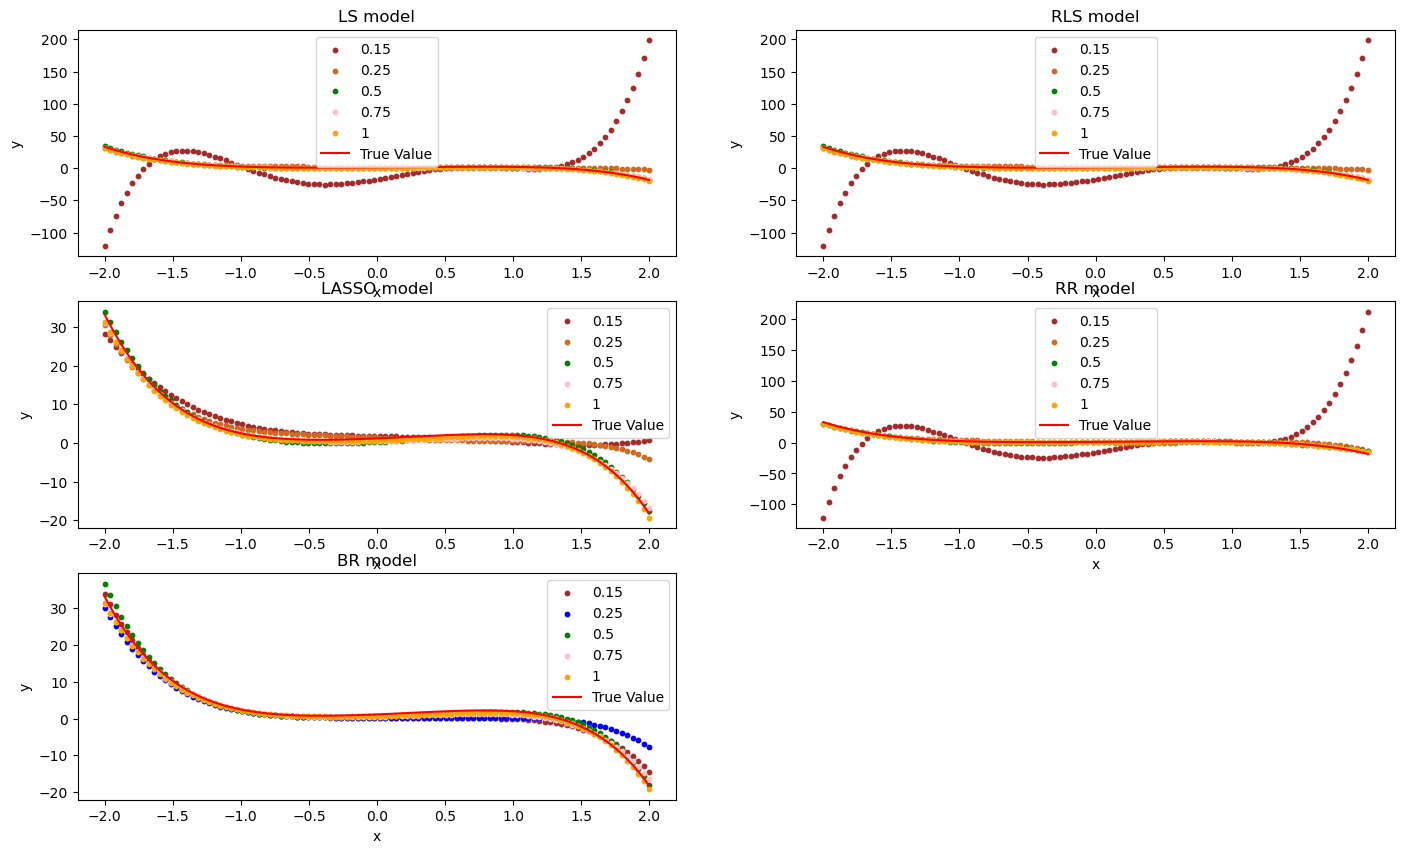

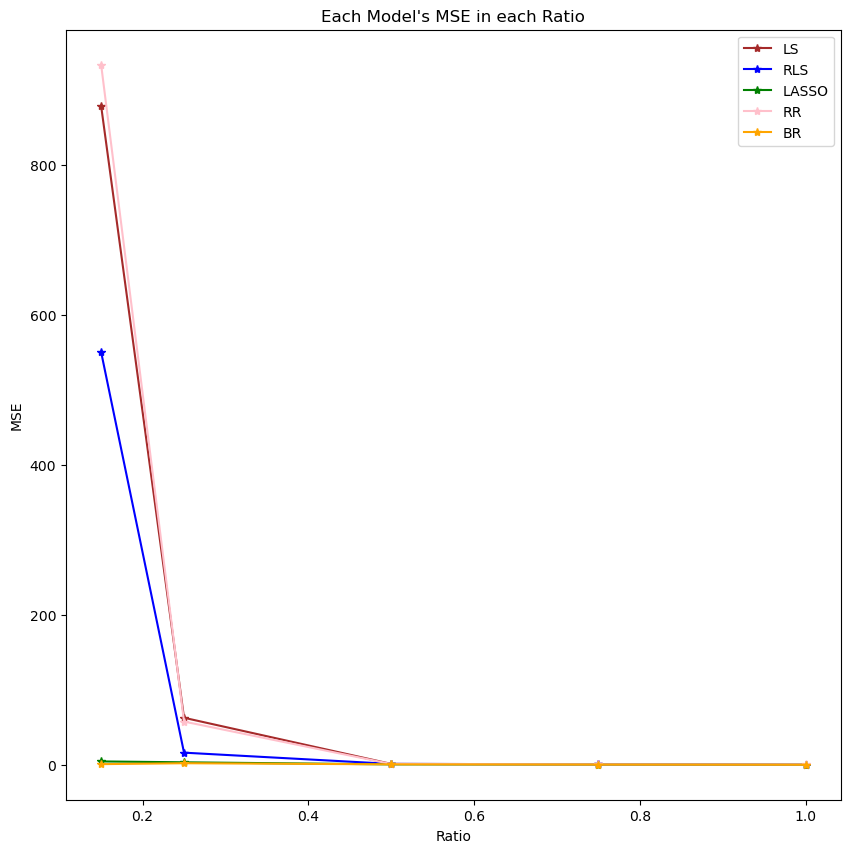

In [10]:
def prob_c():
    ratio_list = [0.15, 0.25, 0.5, 0.75, 1]
    model_dict = {}
    model_dict_mse = {}
    l,m, X, Y =data_processing()
    
    for ratio in ratio_list:
        alist = []
        for i in range(5):
            pred_dict, mse_list = analysis(ratio=ratio, pro='c')
            model_dict[ratio] = pred_dict
            alist.append(mse_list)   
        mse = np.array(alist).mean(axis=0)
        model_dict_mse[ratio] = {'LS':mse[0], 'RLS':mse[1], 'LASSO':mse[2], 'RR':mse[3], 'BR':mse[4]}    
    plot_probc_est(X, Y, model_dict)   
    plot_std_size(ratio_list, model_dict_mse) 
    
prob_c()

### Problem d
In this problem, I add some outlier is 500 time of orignal sampley. And each model performance with outliers was displayed in below charts. 
According to the MSE of each model, the RR model performed best, and LS model performed sensitive to those outliers. 
Because the least square will enpower each sample with sample weight, which lead those models perform non-ideal when the sample has some outliers can these outlier cannot be filtered but need to be trained for regression.
Besides, since those least square use the $L_2$ norm, which is known to be prone to large estimation error if there are outliers in the training sample.
But to the RR, it down-weights the influence of outliers, which makes their residuals larger and easier to identify.

c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply


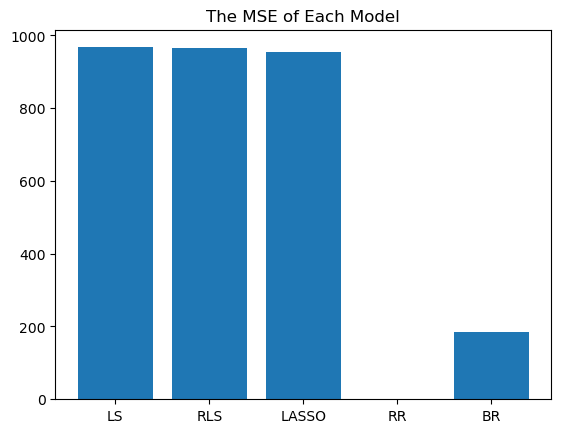

MSE of LS: 967.2361100466841
MSE of RLS: 966.4695217913905
MSE of LASSO: 955.3156465633906
MSE of RR: 0.5635669623737695
MSE of BR: 183.63440947515136


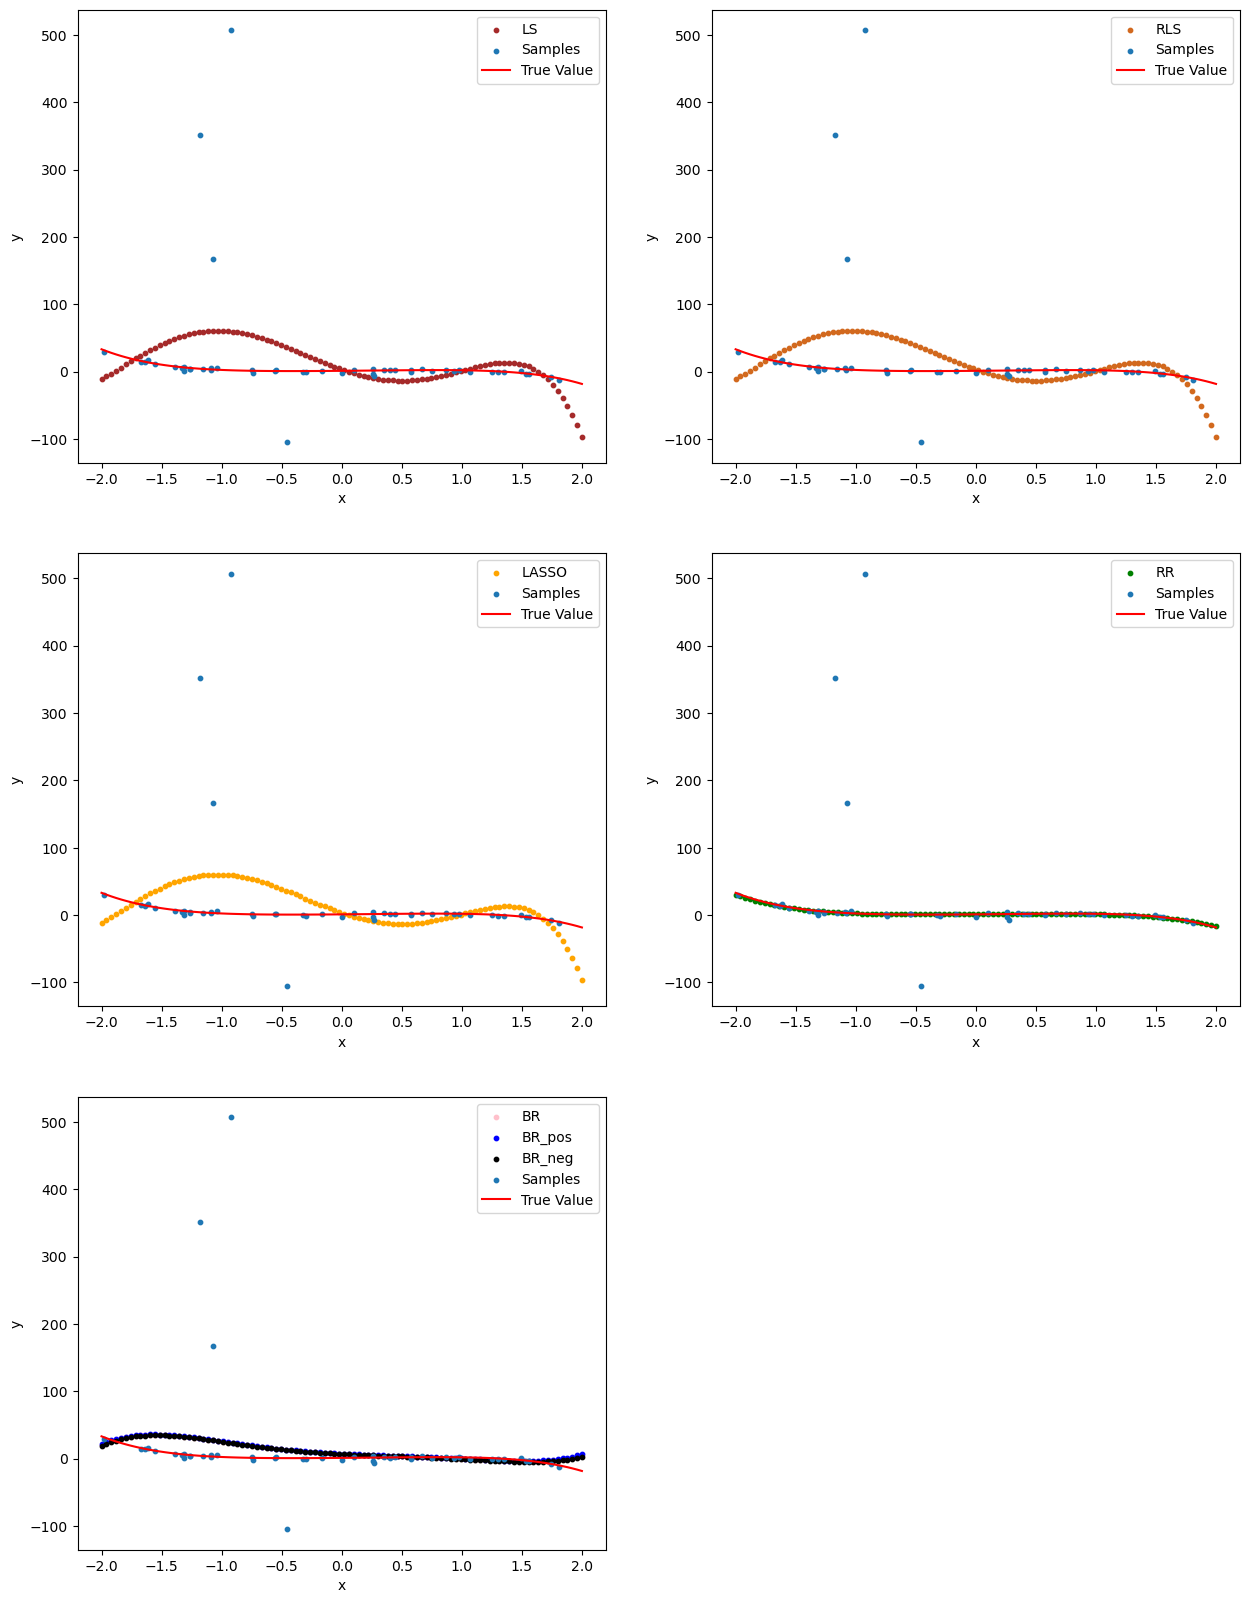

In [12]:
analysis(ratio=1, K=5, pro='d', outlier=100)


### Problem e
I repeat (b) but estimate a higher-order polynomial and set the K=10.
According to the charts below, can get that the LS, RLS and RR tend to overfit the data when learning a more complex model
and LASSO, BR 's estimate function were closed to the true values.

c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply


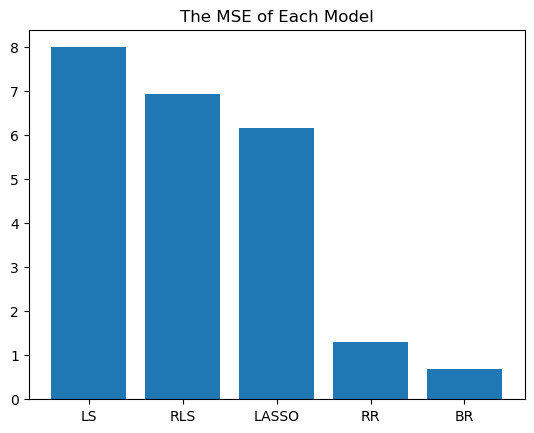

MSE of LS: 7.983106590193071
MSE of RLS: 6.929401524586747
MSE of LASSO: 6.1427147417718775
MSE of RR: 1.2898574921007475
MSE of BR: 0.6891047096909112


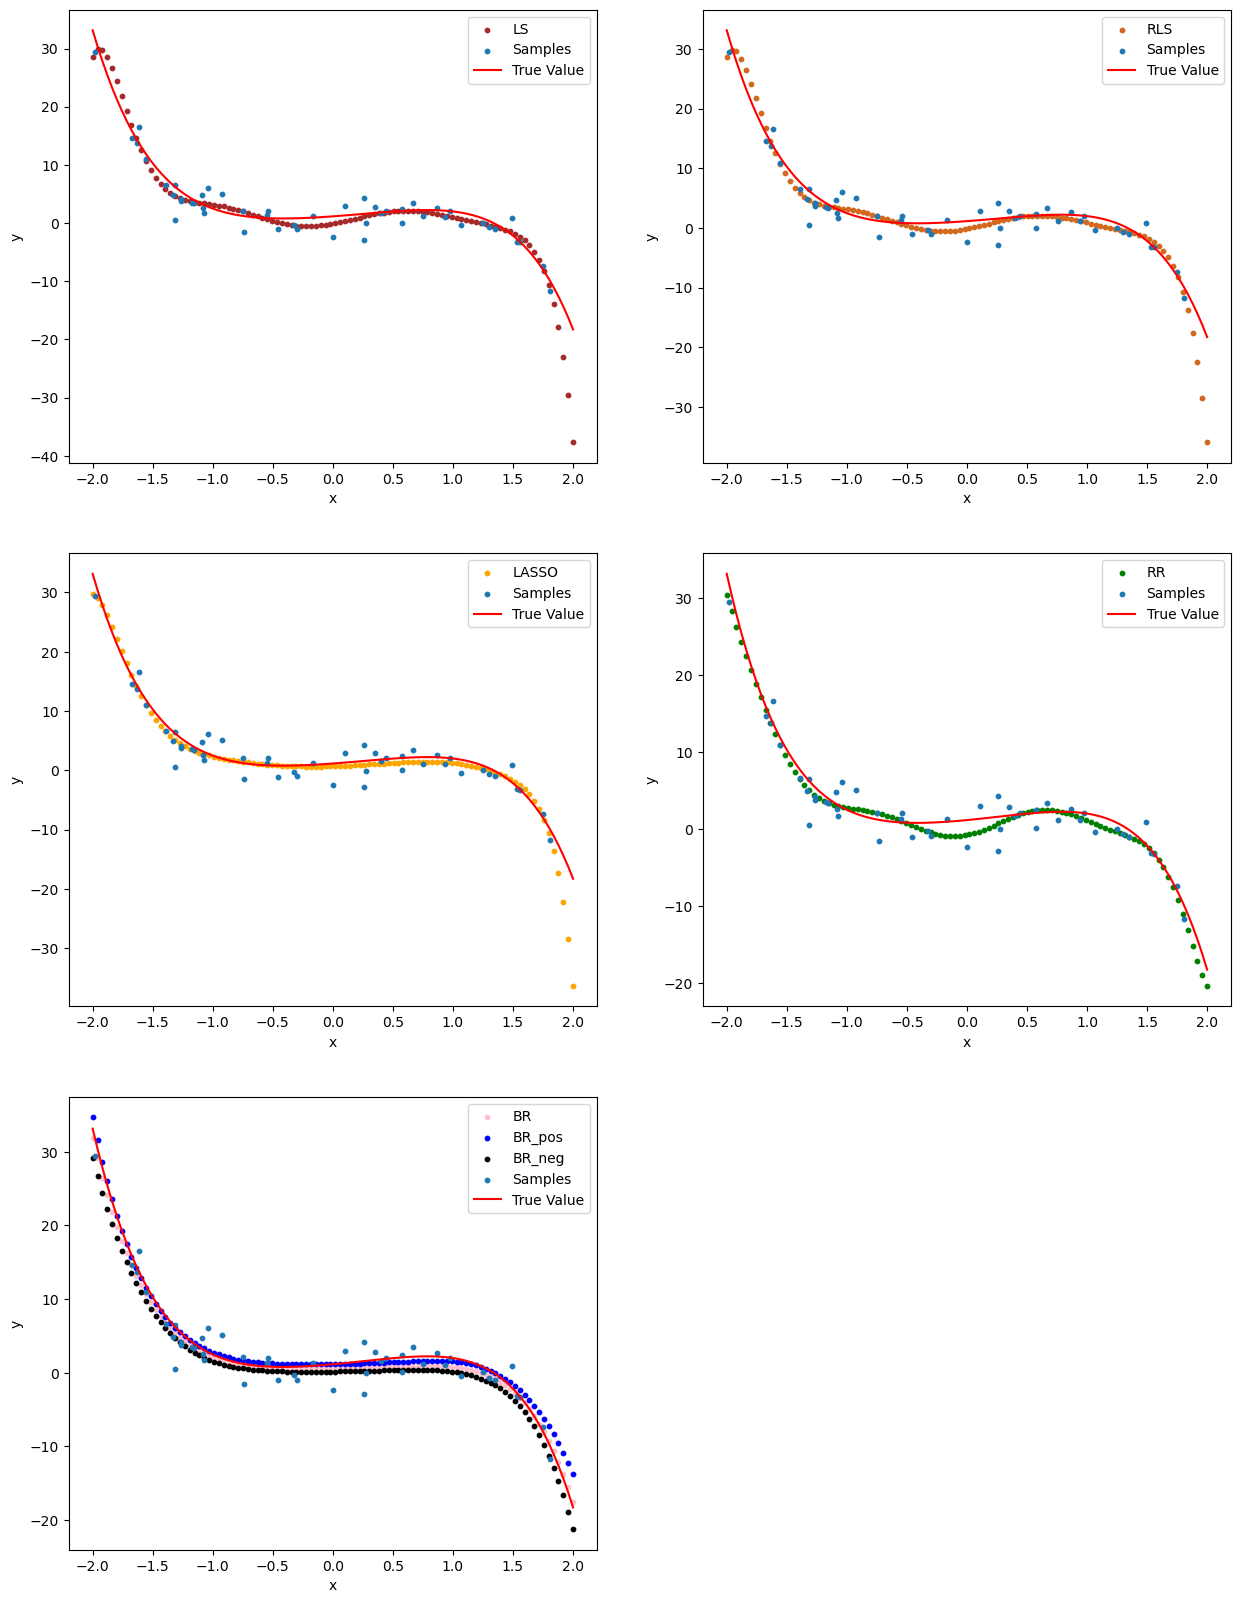

In [13]:
analysis(ratio=1, K=10, pro='e')

## Part 2

### Problem a
Based on the result of each model's MSE and MAE, can get the RLS works best 
Plot the test predictions and the true counts as follows
To the discussion of any interesting findings:
It can be seen from the below figures that all the predictive models behave well when the number of people is huge or small. However, when the number of people is in the middle, which is around 10 to 15 and 20 to 25, all models have predicted values is litte far from the real value. 

c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply


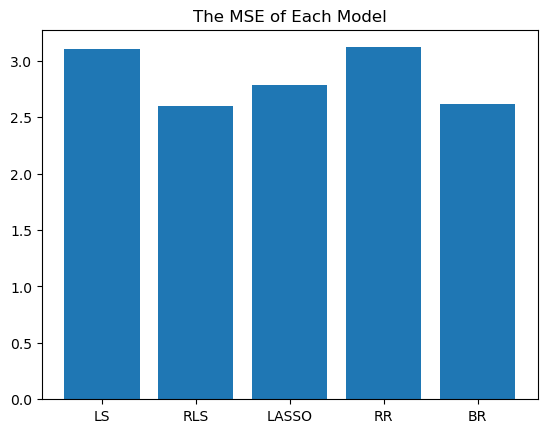

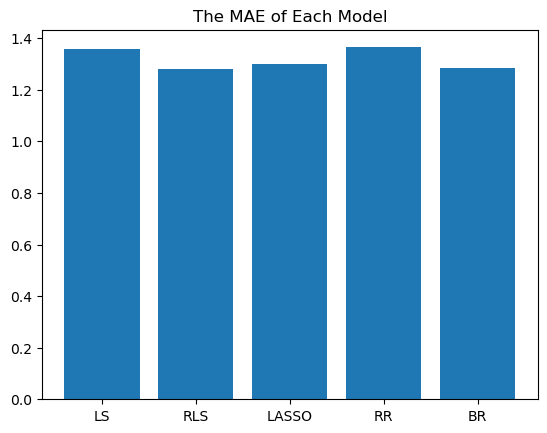

MSE of LS: 3.102838014134246
MSE of RLS: 2.5978793141470065
MSE of LASSO: 2.782724076612656
MSE of RR: 3.118997118962825
MSE of BR: 2.618733922241957
MAE of LS: 1.3584435211465367
MAE of RLS: 1.279905113299301
MAE of LASSO: 1.3008751101061713
MAE of RR: 1.364567082152389
MAE of BR: 1.2824328557329046


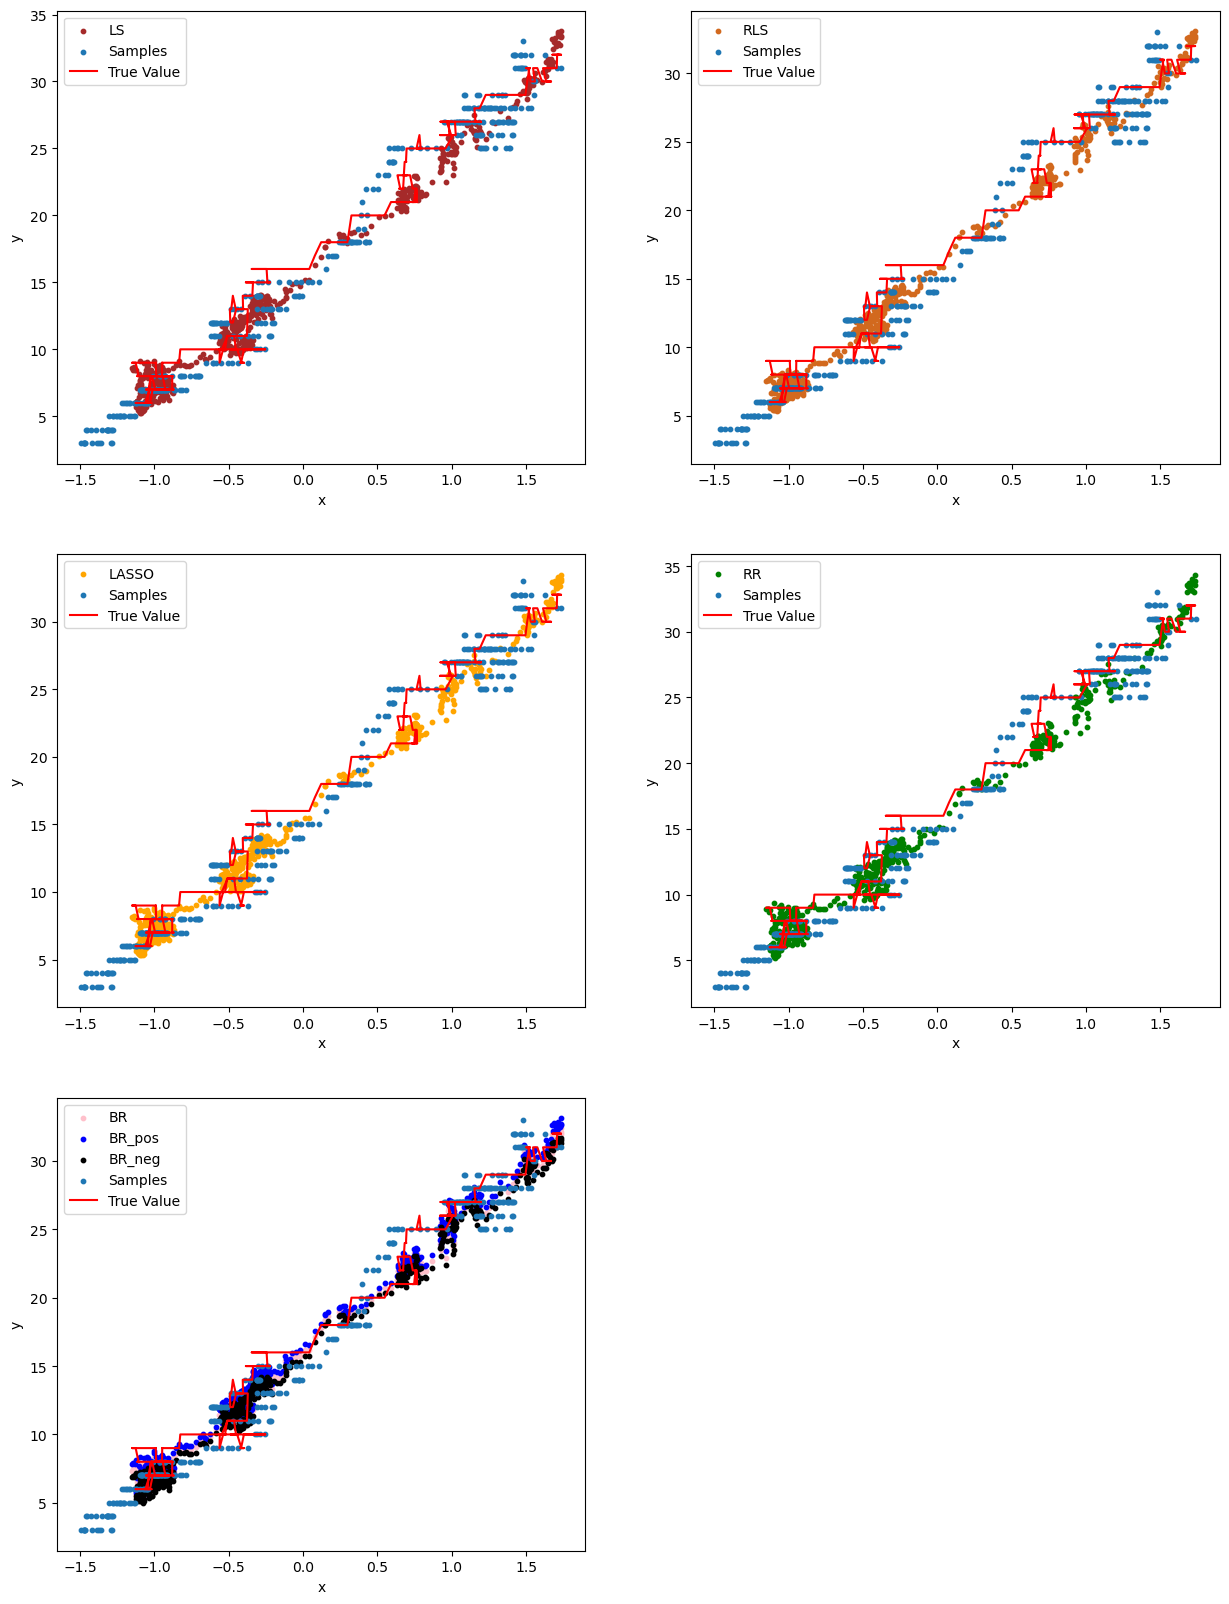

In [14]:
analysis(part=1)


### Problem b
1. First I implement the $\phi(x)$ is $[x_1,...,x_9,(x_1)^2,...(x_9)^2]^T$ and get the following trail results. 
   After improving the $\phi(x)$ into this mode, the MAE and MSE of each model performed better than problem a, which $\phi(x)$ is x. Those results performed better than problem a) 
2. Then, I add the $x_ix_j$ into the $\phi(x)$, depend on use previous $\phi(x)$ in 1. and do the $\phi(x)\phi(x)^T$. Then I select the items of uppertriangular from this matrix, which are all the $x_ix_j$
3. I add transform the $\phi(x)$ with 3rd order like $x^3$, base on the 1.. and get the better performance than problem a)

### Problem b 1.

c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply


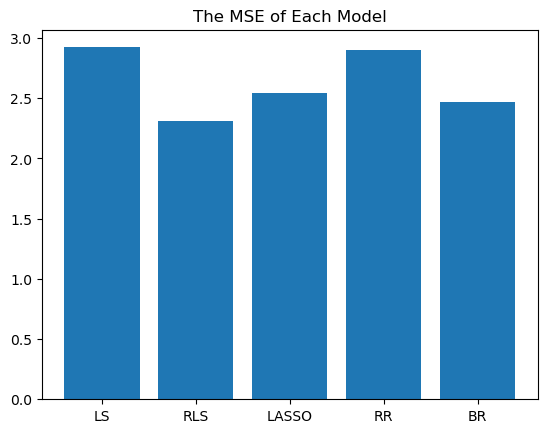

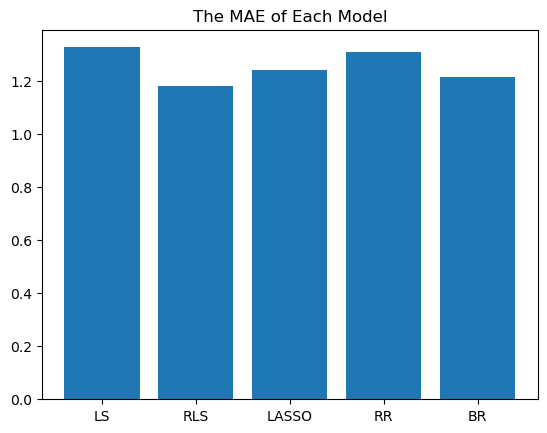

MSE of LS: 2.923594026734244
MSE of RLS: 2.314812148513016
MSE of LASSO: 2.5452142083552824
MSE of RR: 2.898128692341148
MSE of BR: 2.4677739025681045
MAE of LS: 1.3267461241114153
MAE of RLS: 1.1818620393828905
MAE of LASSO: 1.2425531540179677
MAE of RR: 1.3079287591847546
MAE of BR: 1.2136987570470137


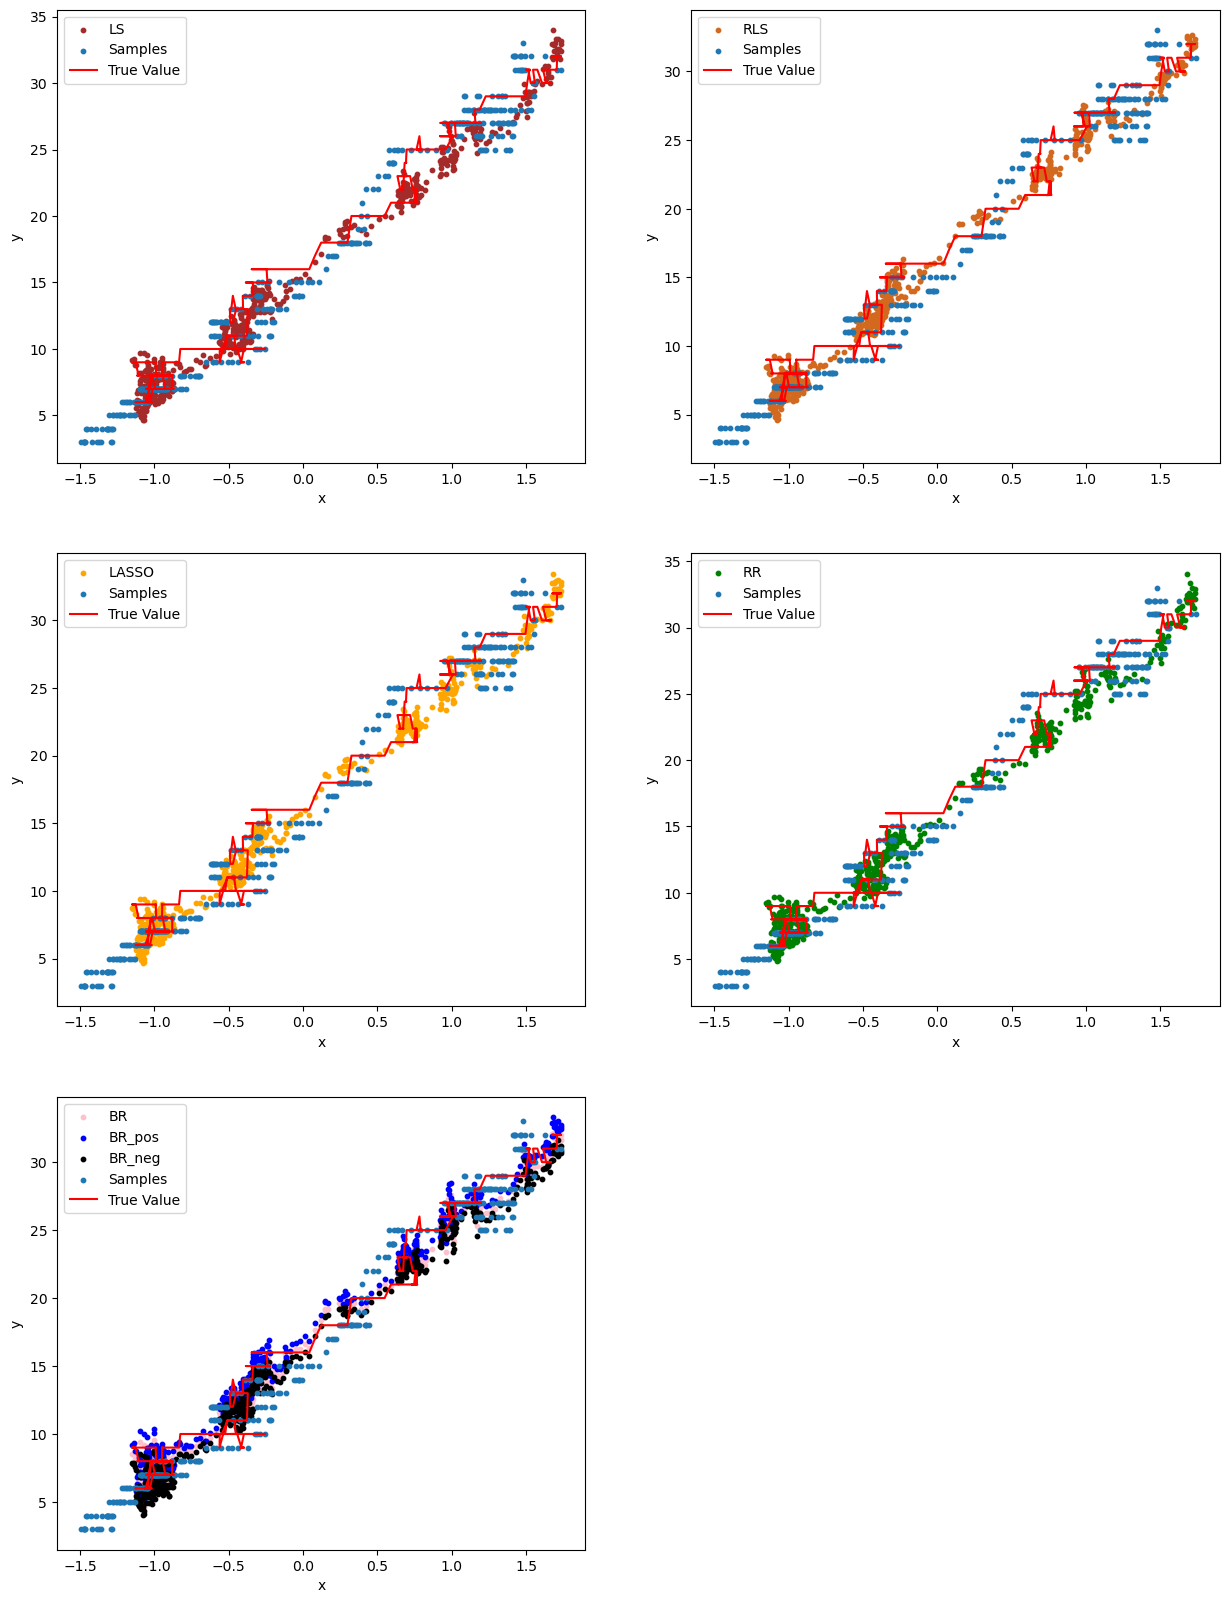

In [15]:
analysis(part=2)

### Problem b 2.

c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply


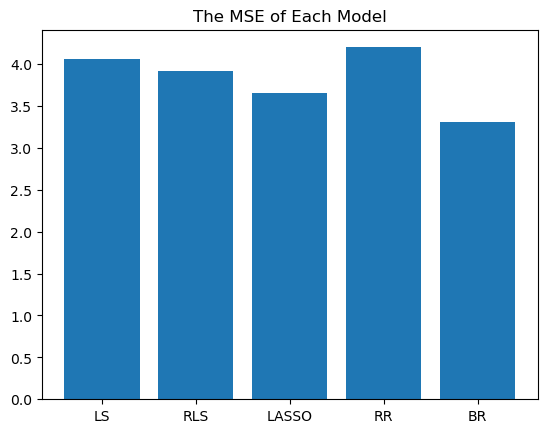

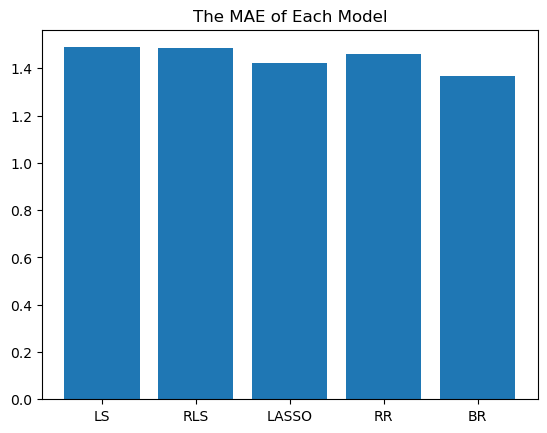

MSE of LS: 4.059714635807797
MSE of RLS: 3.9217133308754644
MSE of LASSO: 3.6506680264170193
MSE of RR: 4.199906460834481
MSE of BR: 3.304269465872169
MAE of LS: 1.4886914191150775
MAE of RLS: 1.4839026857814916
MAE of LASSO: 1.4240020795213721
MAE of RR: 1.4601520059695001
MAE of BR: 1.3656207673876684


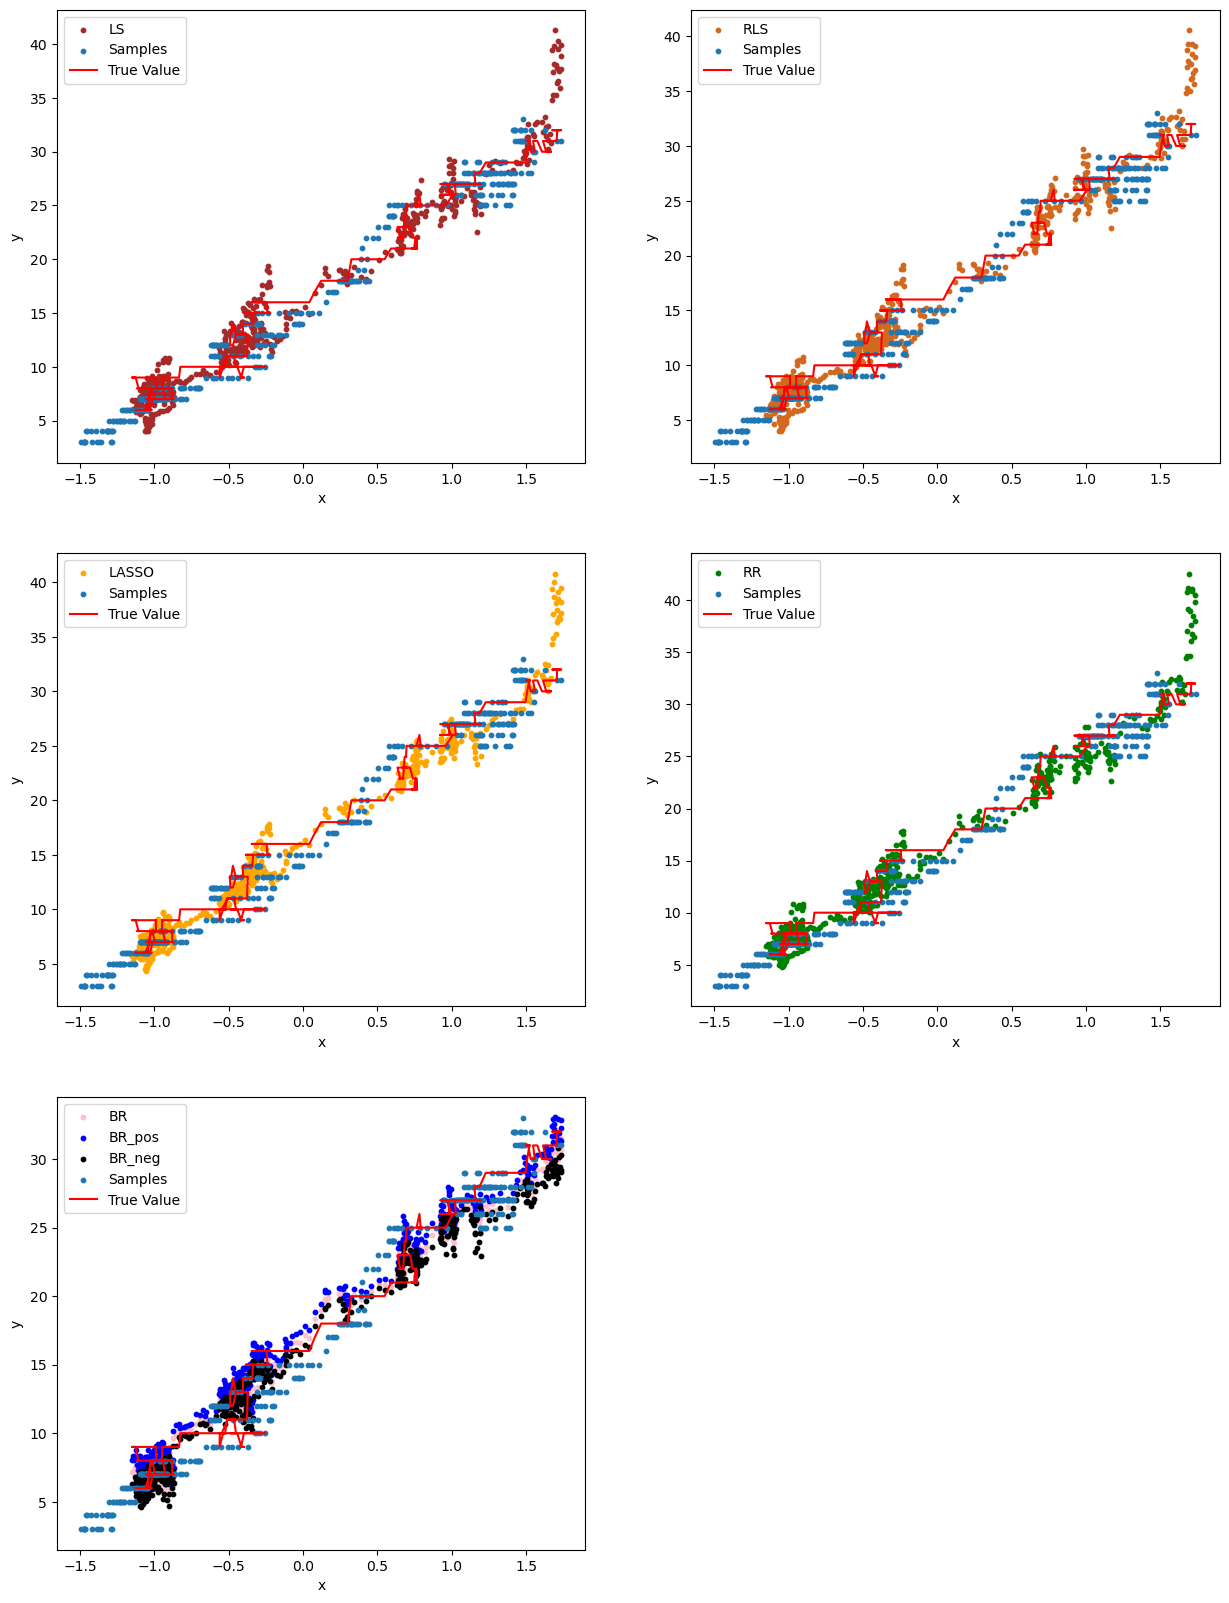

In [16]:
analysis(part=3)

### Problem b 3.

c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply


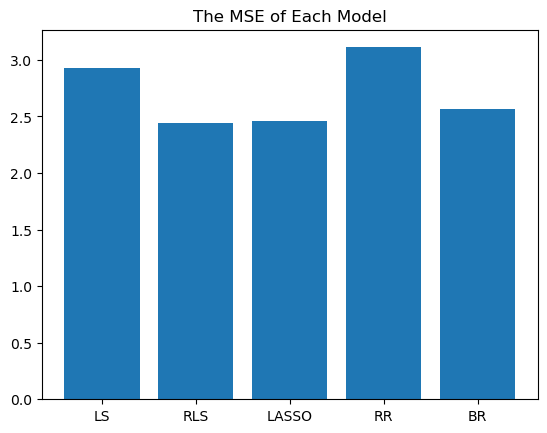

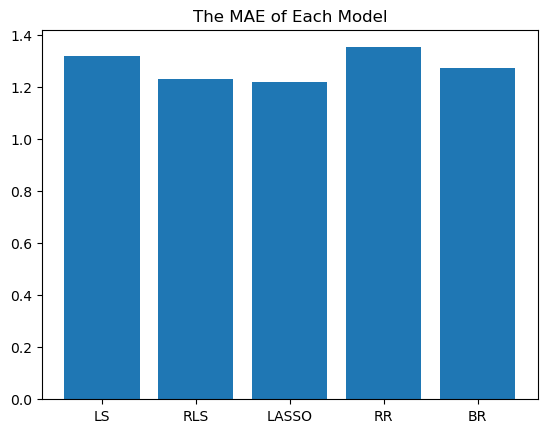

MSE of LS: 2.928288067211331
MSE of RLS: 2.4393685900701576
MSE of LASSO: 2.4597543046897057
MSE of RR: 3.111646272716377
MSE of BR: 2.5622208274667106
MAE of LS: 1.3191990563261018
MAE of RLS: 1.2316043360224
MAE of LASSO: 1.2185566820616565
MAE of RR: 1.3517843231497306
MAE of BR: 1.2712200828207196


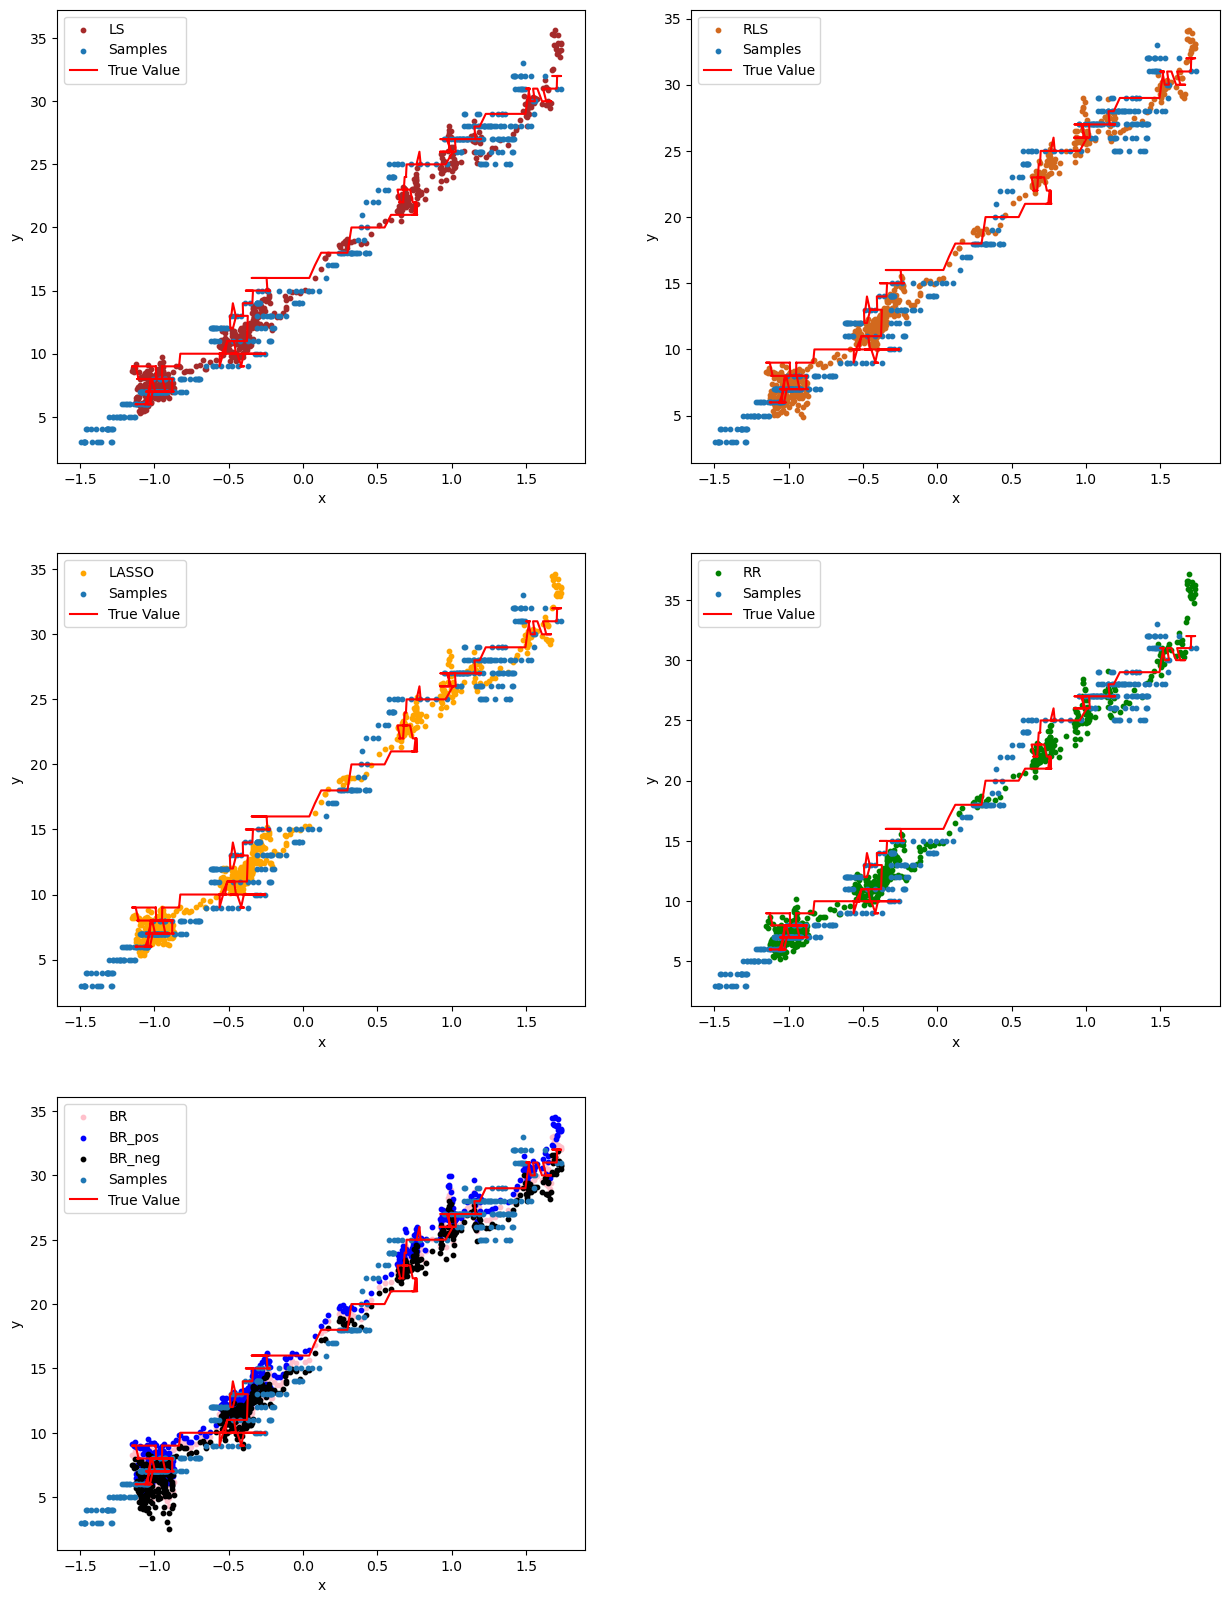

In [17]:
analysis(part=4)

## Reference of library in my code
1. Numpy for process and load the data for regression, and do the matrix calculation. [Numpy](https://numpy.org/)
2. CVXOPT for do the optimizing to solve the QP and LP problrm. [CVXOPT](https://cvxopt.org/)
3. matplot.pyplot for plot each chart in this assignment. [matplot.pyplot](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.html)